## Raster data operations
Raster data is an imporant format of spatial data. In this tutorial, we are going to using Python to manipulate the raster data format. We will work with `RasterIO` and `Numpy` for the raster data processing. RasterIO is a modern library to work with geospatial data in a gridded format. It excels at providing an easy way to read/write raster data and access individual bands and pixels as numpy arrays.

`RasterIO` is built on top of the popular `GDAL` (Geospatial Data Abstraction Library). GDAL is written in C++ so the Python API provided by GDAL is not very intuitive for Python users. RaserIO aims to make it easy for Python users to use the underlying GDAL library in an intuitive way.

In this section, we will clip a large remote sensing images into different clips and then merge them together.

### Prepare the Python modules

In [16]:
import os, os.path
import numpy as np
import rasterio as rio
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import get_data_window
from rasterio.windows import Window
from rasterio.merge import merge
# optional - turn off warnings
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

### Read the raster data and get the metadata of the raster data

Download the NAIP multispectral imageries. 

https://naipblobs.blob.core.windows.net/naip/v002/pa/2017/pa_100cm_2017/39075/m_3907506_ne_18_1_20170611.tif

In [32]:
naip_file = '../../data/m_3907507_ne_18_060_20190726.tif'
# naip_file = './naip-tiles/row0-col0.tif'
naip_dataset = rio.open(naip_file)
naip_bounds = naip_dataset.bounds
naip_bounds

BoundingBox(left=483780.0, bottom=4420626.0, right=489534.0, top=4427976.0)

In [33]:
naip_dataset.crs

CRS.from_epsg(26918)

In [34]:
naip_dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 9590,
 'height': 12250,
 'count': 3,
 'crs': CRS.from_epsg(26918),
 'transform': Affine(0.6, 0.0, 483780.0,
        0.0, -0.6, 4427976.0)}

### Display the NAIP image

In [35]:
def display_naip_tile(filename, dsfactor = 2):
    """
    Display a NAIP tile using rasterio.
    
    dsfactor: downsample factor
    For .mrf-formatted tiles (which span multiple files), 'filename' should refer to the 
    .mrf file.
    """
    
    # NAIP tiles are enormous; downsize for plotting in this notebook
    
    with rasterio.open(filename) as raster:
        # rasterio uses 1-based indexing for channels.
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        ir = raster.read(1, out_shape=(1, h, w))
        r = raster.read(2, out_shape=(1, h, w))
        g = raster.read(3, out_shape=(1, h, w))

    cir = np.dstack((ir,r,g))
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100, edgecolor='k')
    plt.imshow(cir)
    raster.close()

Resampling to 2000,2000


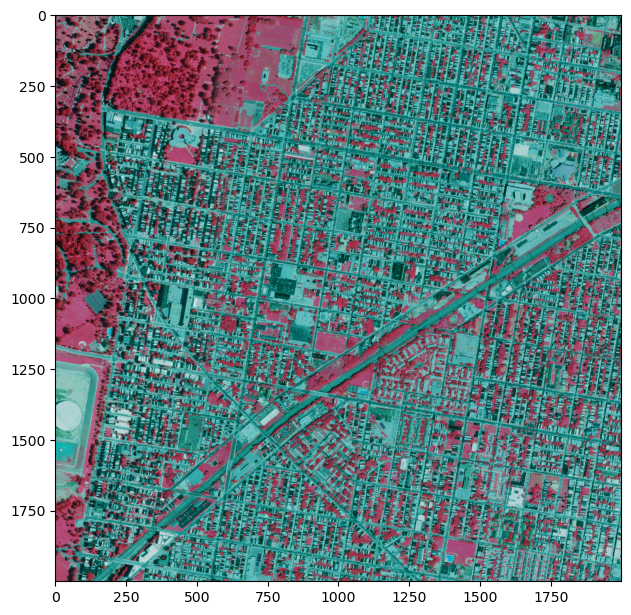

In [36]:
# display_naip_tile(naip_file)

naip_file = '../../data/naip-tiles/row0-col0.tif'
display_naip_tile(naip_file)


### Read the raster data into a numpy array

In [22]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
green = np.float32(naip_dataset.read(3))
red = np.float32(naip_dataset.read(2))
nir = np.float32(naip_dataset.read(1))


# plt.imshow(band1)

<Figure size 720x720 with 0 Axes>

In [23]:
np.float32(green)

array([[ 54.,  53.,  40., ..., 159., 155., 153.],
       [ 55.,  44.,  45., ..., 158., 156., 154.],
       [ 45.,  32.,  52., ..., 151., 154., 156.],
       ...,
       [170., 157., 164., ...,  48.,  44.,  42.],
       [179., 168., 163., ...,  52.,  45.,  44.],
       [185., 176., 163., ...,  67.,  58.,  51.]], dtype=float32)

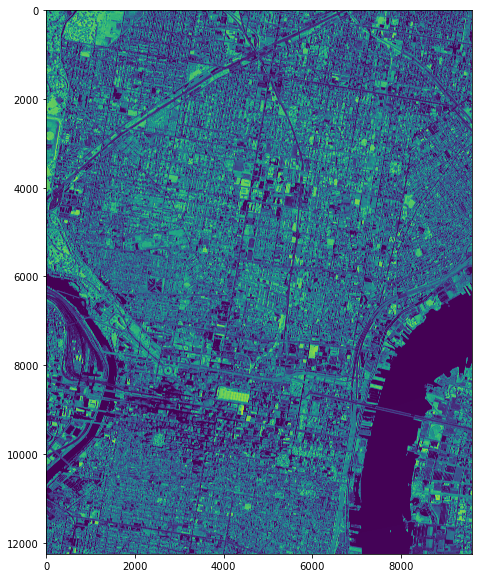

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(nir)

### Calculate the NDVI from NAIP image

In [25]:
ndvi = (nir - red)/(nir + red + 0.000001)

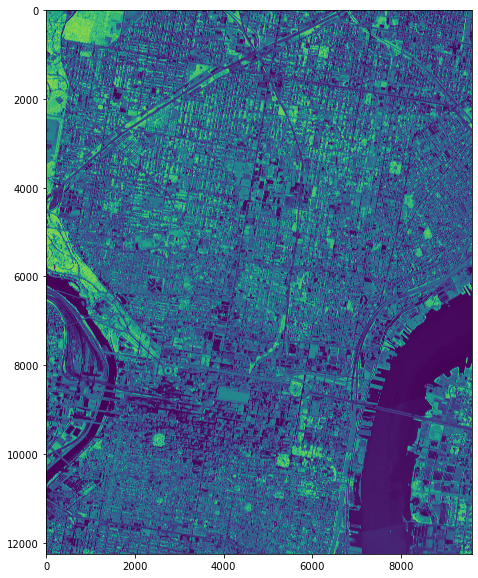

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(ndvi)

In [27]:
ndvi.max()

0.9770115

### Extract vegetation from NAIP image

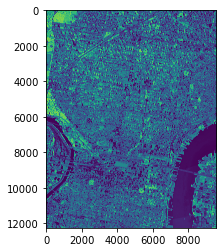

In [28]:
plt.imshow(ndvi)
veg = np.zeros((ndvi.shape[0], ndvi.shape[1]), dtype = np.uint16)
veg[ndvi > 0] = 1

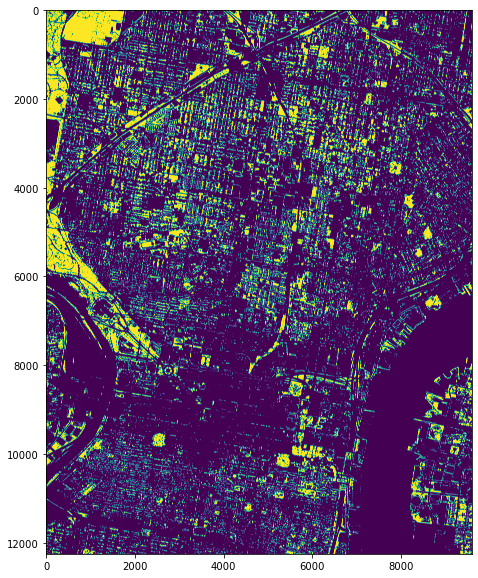

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(veg)

In [40]:
veg.shape

(1, 12250, 9590)

### Save raster data as a new tif

In [41]:
out_tif = 'veg.tif'
# prepare the schema of the new tiles
out_meta = naip_dataset.meta.copy()
out_meta.update({'count': 1,
                'dtype': 'uint16',
                 "height": ndvi.shape[0],
                 "width": ndvi.shape[1],
#                  "transform": out_transform,
                 "crs": naip_dataset.crs, 
                 'compress': 'lzw'}
               )

# this is required, because rio will use three dimension, even this is single band image
veg = veg.reshape(1, veg.shape[1], veg.shape[2])

with rio.open(out_tif, "w", **out_meta) as dest:
    dest.write(veg)
    

### Clip a large raster data into small tiles

In [10]:
# height and width of the raster
height, width = naip_dataset.shape

# split the large raser into number of tiles, tile size is 2000*2000
tile_width = 4000
tile_height = 4000


tile_num_col = int(width/tile_width) + 1
tile_num_row = int(height/tile_height) + 1


In [11]:
outfolder = './naip-tiles'
# the output folder
if not os.path.exists(outfolder): os.mkdir(outfolder)


In [12]:

# create each tile
for i in range(tile_num_row - 1):
    # loop each column
    for j in range(tile_num_col - 1):
        print('The i and j is:', i, j)
        tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
        
        row_start = i*tile_height
        col_start = j*tile_width
        row_end = (i + 1)*tile_height
        col_end = (j + 1)*tile_width
        
        # deal with the right boundary
        if row_end > height - 1: 
            tile_height = height - row_start
        if col_end > width - 1: 
            tile_width = width - col_start
        
        # window = get_data_window(lu_dataset.read(1, masked=True))
        window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
        
        kwargs = naip_dataset.meta.copy()
        kwargs.update({
            'height': window.height,
            'width': window.width,
            'transform': rio.windows.transform(window, naip_dataset.transform)})
        
        with rio.open(tilename, 'w', **kwargs) as dst:
            dst.write(naip_dataset.read(window=window))
            

The i and j is: 0 0
The i and j is: 0 1
The i and j is: 1 0
The i and j is: 1 1
The i and j is: 2 0
The i and j is: 2 1


In [13]:
tilename

'./naip-tiles/row2-col1.tif'

### Mosaic Raster data together

In [29]:
dirpath = './naip-tiles'

In [43]:
# start to mosaic the raster tiles
tiflist = []

for file in os.listdir(dirpath):    
    if file.endswith('.tif'):
        tiffile = os.path.join(dirpath, file)
        tiflist.append(tiffile)

src_files_to_mosaic = []
for fp in tiflist:
    tile_src = rio.open(fp)
    src_files_to_mosaic.append(tile_src)


In [46]:
print('The number of mosaiced tiles is:', len(src_files_to_mosaic))
outfile = 'mosaicedNAP.tif'

# the method can be set as min, max..
mosaic, out_trans = merge(src_files_to_mosaic) #, method='max'
print('You have mosaiced the results')


# Prepare the schema of the output mosacied image
out_meta = tile_src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans, 
                  "compress": 'lzw',
                  'BIGTIFF': 'YES'
                  }
               )
            
#out_fp = os.path.join(dirpath, 'atlanta-naip.tif')
with rio.open(outfile, "w", **out_meta) as dest:
     dest.write(mosaic)

The number of mosaiced tiles is: 6
You have mosaiced the results


### Mask by polygon

In [113]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 9590,
 'height': 12250,
 'count': 3,
 'crs': CRS.from_epsg(26918),
 'transform': Affine(0.6, 0.0, 483780.0,
        0.0, -0.6, 4427976.0)}

In [137]:
import fiona
import rasterio

# digital surface model
shpfile = '../../data/mms-nsf.shp'
input_value_raster = '../../data/m_3907507_ne_18_060_20190726.tif'
out_raster = '../../data/cliped-raster.tif'


with fiona.open(shpfile, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(input_value_raster) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "compress": 'lzw',
                 "transform": out_transform})

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)    


Resampling to 1314,1317


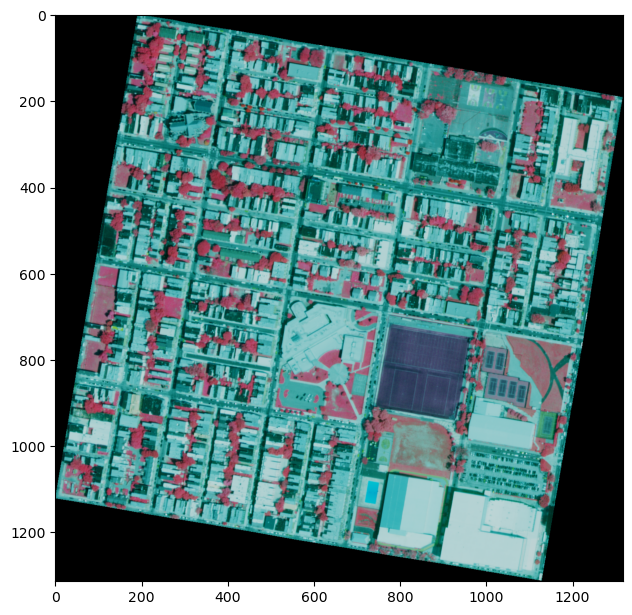

In [145]:
display_naip_tile(out_raster, 1)

In [141]:
img = rasterio.open(out_raster)
nir = np.float32(img.read(1))
red = np.float32(img.read(2))
ndvi = (nir - red)/(nir + red + 0.000001)

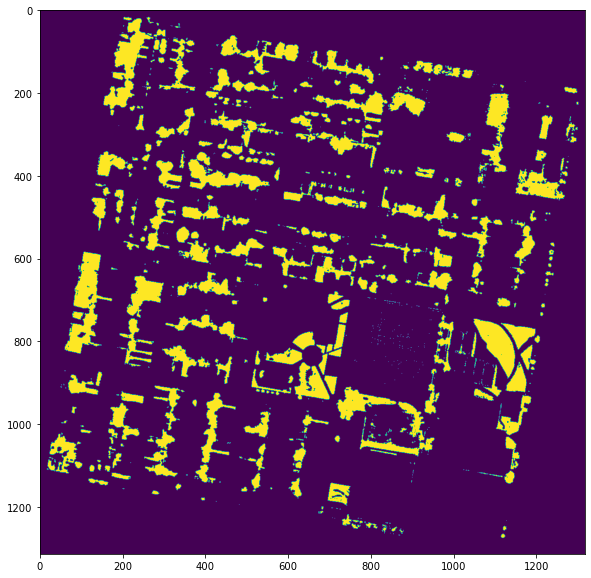

In [143]:
veg = np.zeros((ndvi.shape[0], ndvi.shape[1]), dtype = np.uint16)

veg[ndvi > 0] = 1
plt.figure(figsize=(10, 10))
plt.imshow(veg)

Assignment
1. Clip the NAIP images into size of 2000*2000
2. Calculate the NDVI
3. mosaic the NDVI as a new images


### Overlay shapefile on raster data

https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

In [ ]:
import fiona
import shapely
from shapely.geometry import shape
import rasterio
import rasterio.mask
import os, os.path
import numpy as np


root = '../../../data/philadelphia'
mrt_raster = os.path.join(root, 'mosaciedMRT.tif') #MRT_phily-2272.tif
lu_raster = os.path.join(root, 'lu_phily.tif')
chm_raster = os.path.join(root, 'mosaicCHM.tif')
dsm_raster = os.path.join(root, 'mosaicGroundDSM.tif')
dem_raster = os.path.join(root, 'mosaicDEM.tif')


input_zone_polygon = os.path.join(root, 'spatial-data/census-tract-data-2272.shp')
# output_shp_res = os.path.join(root, 'spatial-data/mrt_census_tract_withbuilding.shp')
output_shp_res = os.path.join(root, 'spatial-data/mrt_census_tract.shp')


# Open the raster datasets
mrt_dataset = rasterio.open(mrt_raster)
lu_dataset = rasterio.open(lu_raster)
chm_dataset = rasterio.open(chm_raster)
dsm_dataset = rasterio.open(dsm_raster)
dem_dataset = rasterio.open(dem_raster)


# Prepare the polygon shapefile and then do the overlay of the raster data and the vector data
lyr = fiona.open(input_zone_polygon)
schema = lyr.schema
# schema['properties']['mrt'] = 'float'
schema['properties']['vegcov'] = 'float'
schema['properties']['chm'] = 'float'
schema['properties']['bdHt'] = 'float'
schema['properties']['imper'] = 'float'

with fiona.open(output_shp_res, 'w', driver = "ESRI Shapefile", crs = lyr.crs, schema=schema) as output:
    for idx, feat in enumerate(lyr):
        props = feat['properties']
        geom = feat['geometry']
        shape = [geom] # the rasterio need the list, therefore, create a list
        
        # mask the raster using the polygon
        outMRT_image, out_transform = rasterio.mask.mask(mrt_dataset, shape, crop=True)
        outLU_image, out_transform = rasterio.mask.mask(lu_dataset, shape, crop=True)
        outCHM_image, out_transform = rasterio.mask.mask(chm_dataset, shape, crop=True)
        outDSM_image, out_transform = rasterio.mask.mask(dsm_dataset, shape, crop=True)
        outDEM_image, out_transform = rasterio.mask.mask(dem_dataset, shape, crop=True)
        
        #print(np.max(outMRT_image), np.min(outMRT_image), np.max(outLU_image), np.min(outLU_image))
        
        # after mask operation, the mrt and lu may have different dimensions
        height = min(outMRT_image.shape[1], outLU_image.shape[1], outCHM_image.shape[1], outDSM_image.shape[1], outDEM_image.shape[1])
        width = min(outMRT_image.shape[2], outLU_image.shape[2], outCHM_image.shape[2], outDSM_image.shape[2], outDEM_image.shape[2])
        
        outMRT_image = outMRT_image[0, 0:height-1, 0:width-1]
        outLU_image = outLU_image[0, 0:height-1, 0:width-1]
        outCHM_image = outCHM_image[0, 0:height-1, 0:width-1]
        outDSM_image = outDSM_image[0, 0:height-1, 0:width-1]
        outDEM_image = outDEM_image[0, 0:height-1, 0:width-1]
        
        ## calculate the percentage of MRT, canopy height, vegetation cover, building height 
        
        # in the land use map, tree 1, grass2, building: 5, water: 4
        outMRT_image[outMRT_image < 0] = 0
        outMRT_image[outLU_image == 5] = 0
        outMRT_image[outLU_image == 255] = 0
        # calculate the mean MRT for all pixels in each census tract
        #mean_val = np.sum(outMRT_image)/np.count_nonzero(outMRT_image)
        
        # average building height
        outDSM_image[outDSM_image < 0] = 0
        outDEM_image[outDEM_image < 0] = 0
        nDSM = outDSM_image - outDEM_image
        nDSM[nDSM < 0] = 0
        nDSM[outLU_image != 5] = 0
        mean_ndsm = np.sum(nDSM)/np.count_nonzero(nDSM)
        
        # the average canopy height
        outCHM_image[outCHM_image < 0] = 0
        mean_chm = np.sum(outCHM_image)/np.count_nonzero(outCHM_image)
        
        # impervious surface percentage, road 6, impervious: 7
        imper_per = (np.count_nonzero(outLU_image == 7) + np.count_nonzero(outLU_image == 6))/np.count_nonzero(outLU_image)
        
        # canopy cover
        vegcov = np.count_nonzero(outLU_image == 1)/np.count_nonzero(outLU_image)
        
        print('vegcov, chm, bdHt, imper', vegcov, mean_chm, mean_ndsm, imper_per)
        #props['mrt'] = mean_val
        props['vegcov'] = vegcov
        props['chm'] = mean_chm
        props['bdHt'] = mean_ndsm
        props['imper'] = imper_per
                
        output.write({'properties': props,
                      'geometry': geom
                     })
        